In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
import pickle

# Min Flow Problems

### Utility Functions

In [3]:
def get_min_flow_problem(graph, dense=False):
    """
    Returns a min flow problem in the form of:
    \min \{ \frac{1}{2}x^TQx + q^Tx : Ex=b, 0 \leq x \leq u \}
    
    Returns
        E      = Incidence Matrix (sparse by default) (dim=m x m),
        Q_diag = Diagonal of the Cost Matrix Q (dim=m)
        q      = Cost Array (dim=m)
        b      = Constraint Array (dim=n)
        upper  = Capacity Array (dim=m)
    """
    E = nx.linalg.incidence_matrix(graph, oriented=True)
    if dense: E = E.dense()

    m, n = graph.number_of_edges(), graph.number_of_nodes()
    
    Q_diag = np.zeros(m)
    q = np.zeros(m)
    upper = np.zeros(m)
    sol = np.zeros(m)
    for i, (u,v,d) in enumerate(graph.edges(data=True)):
        if "capacity" in d:
            upper[i] = d["capacity"]
        if "lcost" in d:
            q[i] = d["lcost"]
        if "qcost" in d:
            Q_diag[i] = d["qcost"]
        if "solution" in d:
            sol[i] = d["solution"]
    
    b = np.zeros(n)
    for i, (u,d) in enumerate(graph.nodes(data=True)):
        if "quantity" in d:
            b[i] = d["quantity"]
    
    if np.allclose(sol, 0):
        sol = None
    
    return E, Q_diag, q, b, upper, sol

In [4]:
def plot_min_flow_problem(G, show_cost=False, show_sol=False, figsize=(12,8), scale=1.0, seed=None, qoff=(-0.07, 0.07)):
    """
    Plots a min flow problem given its graph.
    
    ver.0.1: colors and node quantity positions are tentative
    ver.0.2: added option to show solution path, flow visualization is still missing
    """
    def shift(pos, x_shift, y_shift):
        return {n:(x + x_shift, y + y_shift) for n,(x,y) in pos.items()}
    
    pos = nx.spring_layout(G, seed=seed)
    quantity_labels = nx.get_node_attributes(G,'quantity')
    capacity_labels = nx.get_edge_attributes(G,'capacity')
    if show_cost: lcost_labels = nx.get_edge_attributes(G,'lcost')
    if show_cost: qcost_labels = nx.get_edge_attributes(G,'qcost')
    fig, ax = plt.subplots(figsize=(12,8))

    nx.draw_networkx_nodes(G, pos, ax=ax, node_size=int(scale*1200), node_color="white", edgecolors="black", linewidths=scale)
    nx.draw_networkx_labels(G, pos, ax=ax, font_size=int(scale*24)) #,font_size=14, font_color="black", font_family="sans-serif")
    nx.draw_networkx_labels(G, shift(pos, qoff[0]*scale, qoff[1]*scale), ax=ax, font_size=int(scale*16), labels=quantity_labels, font_color="blue")
    nx.draw_networkx_edges(G, pos, ax=ax, arrowsize=int(scale*20), arrowstyle="-|>", node_size=int(scale*1200), width=int(scale*4))
    nx.draw_networkx_edge_labels(G, pos, ax=ax, edge_labels=capacity_labels, font_size=int(scale*20))
    if show_cost: nx.draw_networkx_edge_labels(G, pos, ax=ax, edge_labels=lcost_labels, font_size=int(scale*12), font_color="orange", label_pos=0.66)
    if show_cost: nx.draw_networkx_edge_labels(G, pos, ax=ax, edge_labels=qcost_labels, font_size=int(scale*12), font_color="red", label_pos=0.33)
    if show_sol:
        sol_edges = nx.get_edge_attributes(G, "solution").keys()
        nx.draw_networkx_edges(G, pos, ax=ax, edgelist=sol_edges, edge_color="gold",
            arrowsize=int(scale*20), arrowstyle="-|>", node_size=int(scale*1200), width=int(scale*4))
    plt.show()

### Example 1: Simple Solvable Problem

In [5]:
G1 = nx.DiGraph()
G1.add_nodes_from(range(0,5))
nx.set_node_attributes(G1, {i:v for i,v in enumerate([2,2,1,1,-6])}, "quantity")

G1.add_edge(0, 1, capacity=5, lcost=1, qcost=1)
G1.add_edge(1, 2, capacity=2, lcost=1, qcost=1)
G1.add_edge(2, 3, capacity=1, lcost=1, qcost=2)
G1.add_edge(4, 0, capacity=6, lcost=1, qcost=1)
G1.add_edge(4, 1, capacity=3, lcost=1, qcost=1)

In [6]:
sol1 = {
    (4, 1): 3,
    (4, 0): 3,
    (0, 1): 1,
    (1, 2): 2,
    (2, 1): 2,
    (2, 3): 1,
}
nx.set_edge_attributes(G1, sol1, "solution")

In [7]:
with open('Data/problem1.pickle', 'wb') as handle:
    pickle.dump(get_min_flow_problem(G1), handle, protocol=pickle.HIGHEST_PROTOCOL)
# loading example
#with open('Data/problem1.pickle', 'rb') as handle:
#    (E, Q_diag, q, b, upper, sol) = pickle.load(handle)

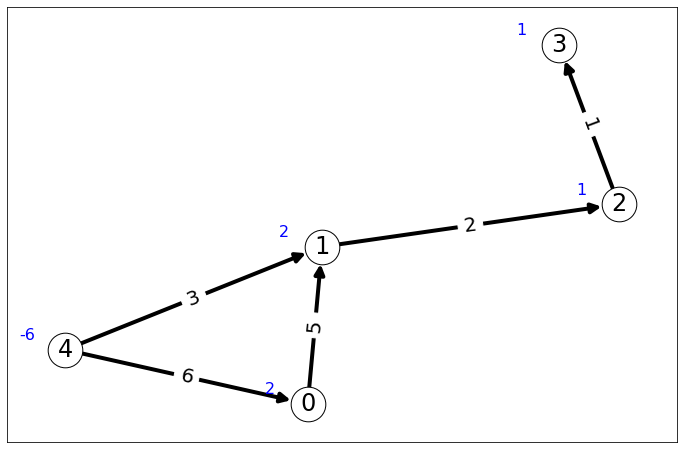

In [8]:
# plot with no costs shown
# blue values are items to be moved
plot_min_flow_problem(G1, scale=1.0, seed=123)

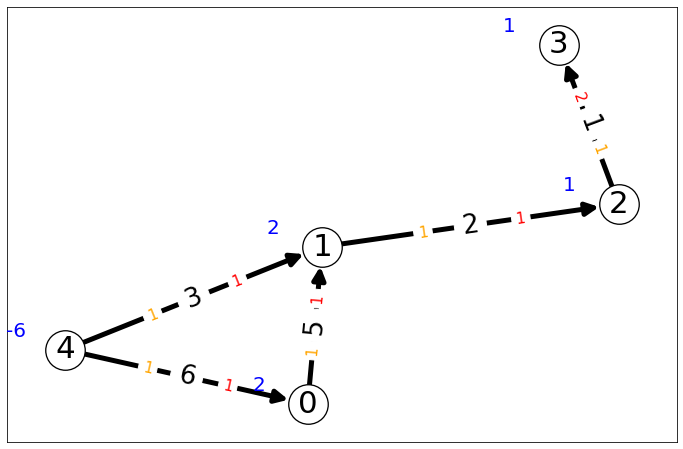

In [9]:
# plot with costs added
# orange (q) are linear scaling edge traversal costs
# red (Q) are quadratically scaling edge traversal costs
plot_min_flow_problem(G1, show_cost=True, scale=1.3, seed=123)

### Example 2: Different Cost Paths

In [10]:
G2 = nx.DiGraph()
G2.add_nodes_from(range(0,7))
nx.set_node_attributes(G2, {i:v for i,v in enumerate([-6,0,0,0,0,0,6])}, "quantity")

G2.add_edge(0, 1, capacity=np.inf, lcost=2, qcost=1)
G2.add_edge(0, 2, capacity=np.inf, lcost=1, qcost=0)
G2.add_edge(1, 3, capacity=np.inf, lcost=2, qcost=1)
G2.add_edge(2, 3, capacity=np.inf, lcost=1, qcost=0)
G2.add_edge(3, 4, capacity=np.inf, lcost=1, qcost=0)
G2.add_edge(3, 5, capacity=np.inf, lcost=2, qcost=1)
G2.add_edge(4, 6, capacity=np.inf, lcost=1, qcost=0)
G2.add_edge(5, 6, capacity=np.inf, lcost=2, qcost=1)

In [11]:
sol2 = {
    (0, 2): 6,
    (2, 3): 6,
    (3, 4): 6,
    (4, 6): 6,
}
nx.set_edge_attributes(G2, sol2, "solution")

In [12]:
with open('Data/problem2.pickle', 'wb') as handle:
    pickle.dump(get_min_flow_problem(G2), handle, protocol=pickle.HIGHEST_PROTOCOL)

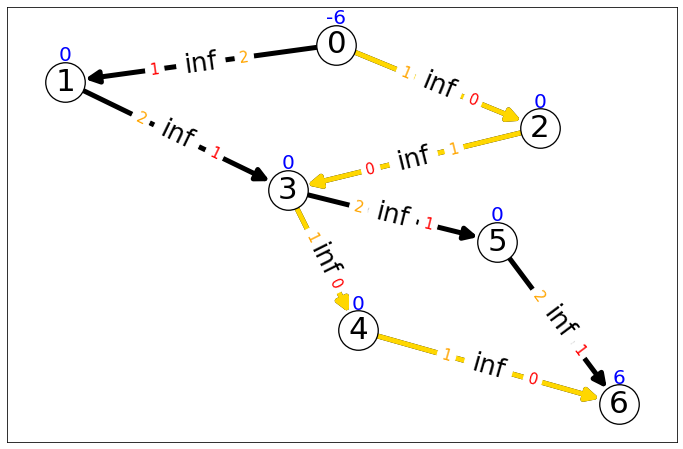

In [13]:
plot_min_flow_problem(G2, show_cost=True, show_sol=True, scale=1.3, seed=123, qoff=(0, 0.1))

### Example 4: [Unsolvable] Insufficient Capacity

In [14]:
G4 = nx.DiGraph()
G4.add_nodes_from(range(0,5))
nx.set_node_attributes(G4, {i:v for i,v in enumerate([2,2,1,1,-6])}, "quantity")

G4.add_edge(0, 1, capacity=5, lcost=1, qcost=1)
G4.add_edge(1, 2, capacity=2, lcost=1, qcost=1)
G4.add_edge(2, 3, capacity=1, lcost=1, qcost=2)
G4.add_edge(4, 1, capacity=3, lcost=1, qcost=1)
G4.add_edge(4, 0, capacity=2, lcost=1, qcost=1)

In [15]:
sol4 = None

In [16]:
with open('Data/problem4.pickle', 'wb') as handle:
    pickle.dump(get_min_flow_problem(G4), handle, protocol=pickle.HIGHEST_PROTOCOL)

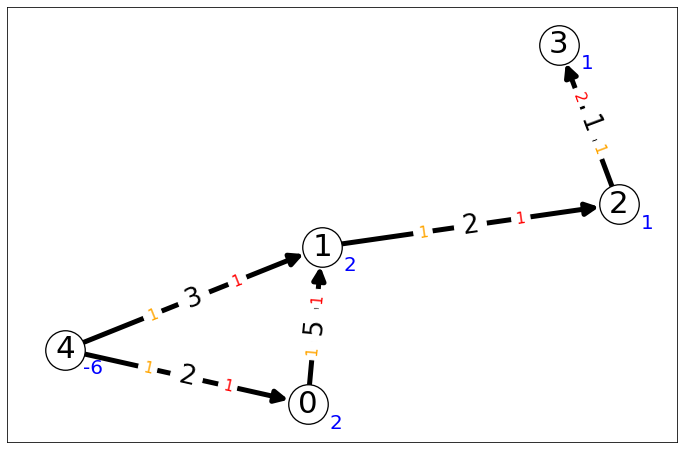

In [17]:
plot_min_flow_problem(G4, show_cost=True, scale=1.3, seed=123, qoff=(0.04,-0.07))

### Example 5: [Unsolvable] No Path Available

In [18]:
G5 = nx.DiGraph()
G5.add_nodes_from(range(0,5))
nx.set_node_attributes(G5, {i:v for i,v in enumerate([2,2,1,1,-6])}, "quantity")

G5.add_edge(0, 1, capacity=5, lcost=1, qcost=1)
G5.add_edge(1, 2, capacity=2, lcost=1, qcost=1)
G5.add_edge(3, 2, capacity=1, lcost=1, qcost=1)
G5.add_edge(4, 1, capacity=3, lcost=1, qcost=1)
G5.add_edge(4, 0, capacity=6, lcost=1, qcost=1)

In [19]:
sol5 = None

In [20]:
with open('Data/problem5.pickle', 'wb') as handle:
    pickle.dump(get_min_flow_problem(G5), handle, protocol=pickle.HIGHEST_PROTOCOL)

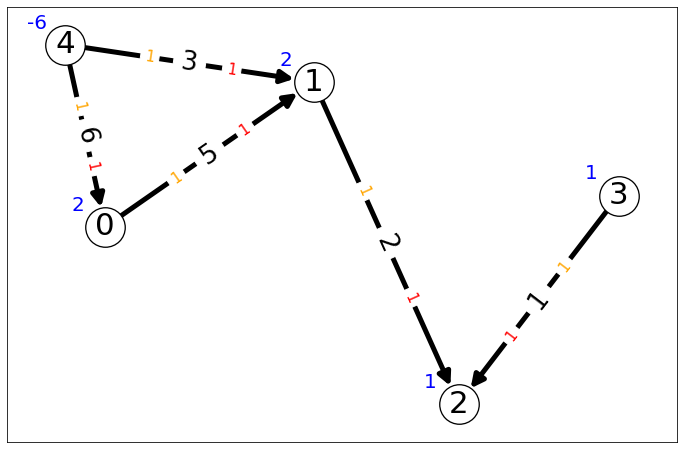

In [21]:
plot_min_flow_problem(G5, show_cost=True, scale=1.3, seed=123)

### Example 6: Medium Sized Graph

In [22]:
# start with a random graph (weakly connected)
G6 = nx.gnm_random_graph(20, 100, seed=123, directed=True)
assert nx.is_weakly_connected(G6)
# set default values
nx.set_node_attributes(G6, 0, "quantity")
nx.set_edge_attributes(G6, 4, "capacity")
nx.set_edge_attributes(G6, 1e5, "lcost")
nx.set_edge_attributes(G6, 1, "qcost")
# add solvable paths
nx.set_node_attributes(G6, {0:-5, 10:5}, "quantity")
G6_path1 = [0, 11, 18, 14, 16, 10]
nx.add_path(G6, G6_path1, capacity=5, lcost=3, qcost=4)
nx.set_node_attributes(G6, {2:-5, 3:5}, "quantity")
G6_path2 = [2, 4, 8, 13, 12, 9, 15, 3]
nx.add_path(G6, G6_path2, capacity=6, lcost=2, qcost=3)

In [23]:
def get_edges_from_path(path):
    prev = path[0]
    edges = []
    for curr in path[1:]:
        edges.append((prev, curr))
        prev = curr
    return edges

In [24]:
sol6 = {**dict([((u,v), 5) for (u,v) in get_edges_from_path(G6_path1)]),
        **dict([((u,v), 5) for (u,v) in get_edges_from_path(G6_path2)])}
nx.set_edge_attributes(G6, sol6, "solution")

In [25]:
with open('Data/problem6.pickle', 'wb') as handle:
    pickle.dump(get_min_flow_problem(G6), handle, protocol=pickle.HIGHEST_PROTOCOL)

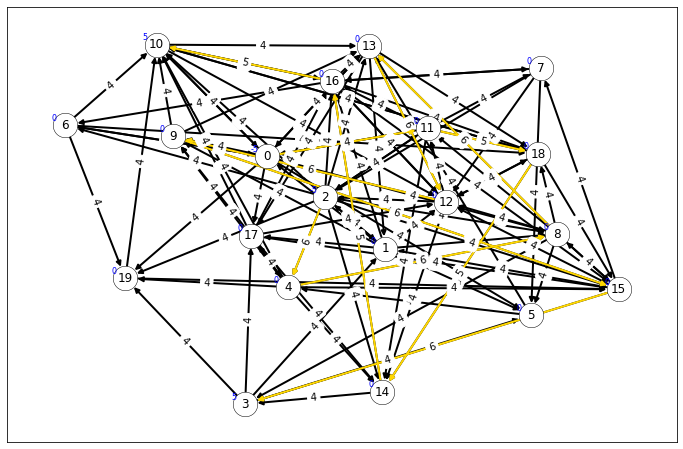

In [26]:
plot_min_flow_problem(G6, show_sol=True, scale=0.5)